# Guess the weight of the fruit cake - Presentation

* data from 2015 Astro Hack Week 
* Estimate Phil's weight
    1. Using crowds estimates of Phil's height, obesity ('overweight', 'normal', 'underweight') to infer Phil's weight
    2. Using crowds own ages, weights, heights, and estimates of Phil's height and age to infer Phil's weight

In [32]:
import numpy as np
import pandas as pd
import corner
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8.0, 6.0) 
plt.rcParams['font.size'] = 20

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## import data

In [16]:
data = pd.read_csv("data.csv")
data.head(5)

,Timestamp,What do you think Phil's height is?,Is Phil...,What do you think Phil's age is?,What is your first name?,What is your own height?,What is your own weight?,What is your own age?,Which is the best text editor?
0,9/28/2015 17:32:57,185.0,Just right,40,John,172,148,35,Sublime
1,9/28/2015 17:47:11,195.6,Just right,44,Lia,160,130,31,emacs
2,9/28/2015 17:52:27,185.0,Just right,37,NaN,182,178,28,vim
3,9/28/2015 17:57:23,180.5,Just right,39,Rebecca,161,145,26,SUBLIME OBVIOUSLY
4,9/28/2015 18:02:57,180.0,Just right,40,Somebody,173,220,39,vim


In [17]:
names = rawdata.columns.tolist()
names = ("t","height","obesity","age","name","ownheight","ownweight","ownage","editor")
data.columns = names
index = (data['obesity'] == 'Just right')
data['obesity'][index] = 'Normal'
hdata = np.array(data["height"])
bdata = np.array(data["obesity"])
pwdata = np.array(data["ownweight"])
phdata = np.array(data['ownheight'])
phdata[phdata == "1,72"] = 172
phdata = np.array([float(i) for i in phdata])
data['ownheight'] = phdata

/home/eric/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## 1.0 A First Model
* Obesity $b$ is related to BMI via the sampling distribution ${\rm Pr}(b|{\rm BMI}) = U[\alpha,\beta]$, where:

| $\alpha$ | $\beta$ | $b$           |
|----------|---------|---------------|
| 12.1     | 18.5    | "Underweight" |
| 18.5     | 24.9    | "Normal"      |
| 24.9     | 31.4    | "Overweight"  |

* w = Phil's true weight
* h = Phil's true height
* a = accuracy of determining obesity
* $\sigma$ = error of height estimation

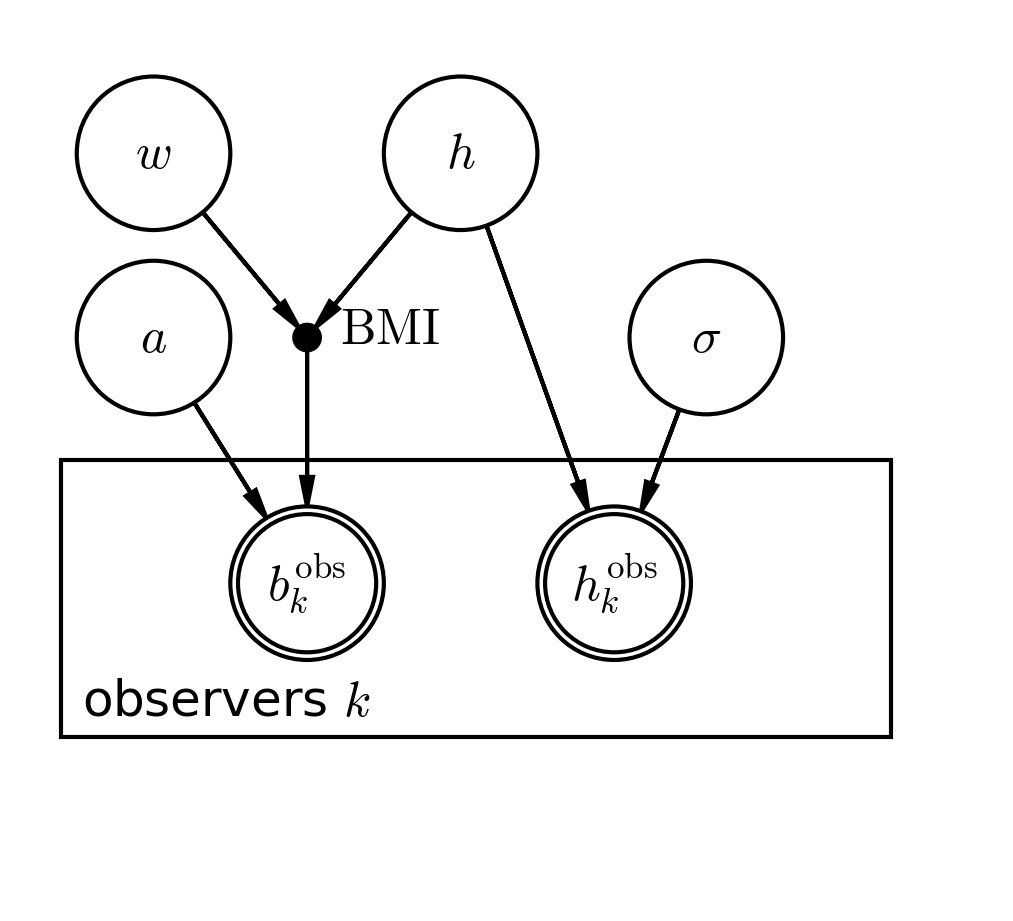

In [29]:
from IPython.display import Image
Image("fruitcake_pgm.png",width = 600)

## Likelihood and Prior
* flat prior for w, h, a, $\sigma$ in reasonable ranges
* Gaussian likelihood for height estimations
* $P(b|BMI) = a$ when $BMI$ in correct range (of obesity $b$), and $P(b|BMI) = \frac{1-a}{2}$ for $BMI$ not in correct range

In [30]:
#flat prior for all variables in a reasonable range
def ln_prior(w,h,a,s):
    wmin, wmax = 50, 300
    hmin, hmax = 150, 200
    amin, amax = 0.5, 1.0
    smin, smax = 0.0, 30.0
    if (w > wmin)*(w < wmax)*(h > hmin)*(h < hmax)*(a > amin)*(a < amax)*(s > smin)*(s < smax):
        logp = 1.0
    else:
        logp = -np.inf
    return logp

#this gives the correct obesity given a BMI
def correct_b(bmi):
    if bmi <= 18.5:
        return 'Underweight' #for underweight
    if 18.5 < bmi < 24.9:
        return 'Normal' #for normal
    if 24.9 <= bmi:
        return 'Overweight' #for overweight

    
def ln_likelihood(w,h,a,s):
    bmi = 0.453529*w/(h/100.)**2
    cb = correct_b(bmi)
    #likelihood from the obesity
    lnprob_b_list = np.zeros_like(bdata)
    for i,b in enumerate(bdata):
        if b == cb:
            lnprob_b_list[i] = np.log(a)
        else:
            lnprob_b_list[i] = np.log((1. - a)/2.)
    lnprob_b = np.sum(lnprob_b_list)
    #likelihood from the height
    lnprob_h_list = np.zeros_like(hdata, dtype='float32')
    for i,hh in enumerate(hdata):
        lnprob_h_list[i] = np.log(1/(np.sqrt(2*np.pi)*s)*np.exp(-(h - hh)**2/(2.*s**2)))
    lnprob_h = np.sum(lnprob_h_list)
    return lnprob_b + lnprob_h
    
def ln_posterior(par_list):
    w,h,a,s = par_list
    return ln_likelihood(w,h,a,s) + ln_prior(w,h,a,s)
    

In [31]:
#simple MCMC sampler
Nsample = 50000
steps = np.array([5.,1.,0.01,0.2])

w_cur = 160.
h_cur = 180.
a_cur = 0.9
s_cur = 6.5
par_cur = np.array([w_cur, h_cur, a_cur, s_cur])
prob_cur = ln_posterior(par_cur)

samples = np.zeros((Nsample,4))
accept = 0
for i in xrange(Nsample):
    par = par_cur + np.array([steps[k]*np.random.randn() for k in range(4)])
    prob = ln_posterior(par)
    if np.exp(prob - prob_cur) > np.random.rand():
        par_cur = par
        prob_cur = prob
        accept += 1
    samples[i] = par_cur
print accept/float(Nsample)

0.62674


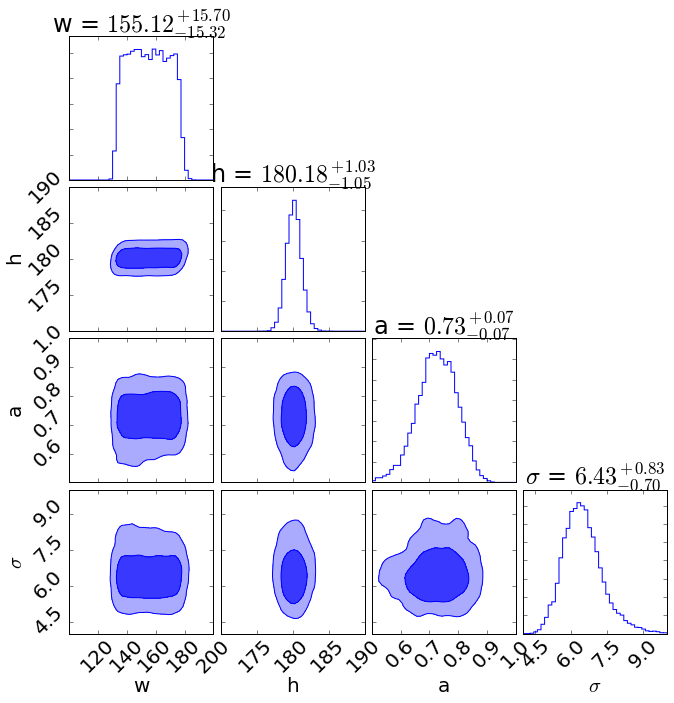

In [131]:
burnin = Nsample/10
wmin, wmax = 100, 200
hmin, hmax = 170, 190
amin, amax = 0.5, 1.0
smin, smax = 4.0, 10.0
corner.corner(samples[burnin:], labels=['w','h','a',r'$\sigma$'],range = [(wmin,wmax),(hmin,hmax),(amin,amax),(smin,smax)]
                ,show_titles=True, title_args={"fontsize": 12},
                plot_datapoints=False, fill_contours=True, levels=[0.68, 0.95], color='b', bins=40, smooth=1.0);
plt.savefig('simple MCMC of the first model.png')
plt.show()



### Our first estimation:  Phil's weight = 155 $\pm$ 15 (lbs)

# 2.0 simple linear regression (only uses height and weight)

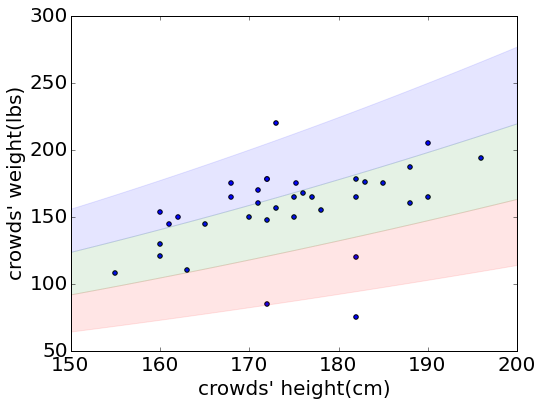

In [134]:
plt.scatter(data['ownheight'],data['ownweight'])
h_list = np.linspace(150,200,50)

plt.fill_between(h_list, (h_list/100.)**2*12.9/0.4539,
                     (h_list/100.)**2*18.5/0.4539, alpha=0.1, color="r")
plt.fill_between(h_list, (h_list/100.)**2*18.5/0.4539,
                     (h_list/100.)**2*24.9/0.4539, alpha=0.1, color="g")
plt.fill_between(h_list, (h_list/100.)**2*24.9/0.4539,
                     (h_list/100.)**2*31.4/0.4539, alpha=0.1, color="b")
plt.xlim([150,200])
plt.xlabel('crowds\' height(cm)')
plt.ylabel('crowds\' weight(lbs)')

In [113]:
BMIlist = data['ownweight']*0.4534/data['ownheight']**2*100**2
select = np.where(np.logical_and(BMIlist > 12.9, BMIlist < 31.4))[0]
phdata, pwdata = np.array(data['ownheight'][select]), np.array(data['ownweight'][select])
AT = np.vstack((phdata, np.ones(len(phdata))))
ATA = np.dot(AT, AT.T)
m, c = np.linalg.solve(ATA, np.dot(AT, pwdata))
yerr = np.std(pwdata - phdata*m - c)
print(m,c,yerr)

(1.5172248389006366, -107.22981912450534, 20.104646767123597)


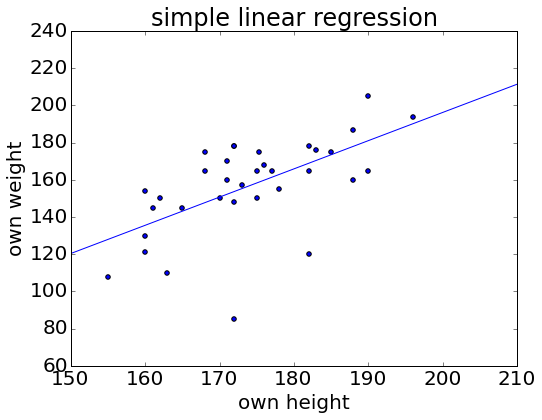

In [114]:
plt.scatter(phdata,pwdata)
x = np.array([100, 300])
y = c + m*x
plt.plot(x,y)
plt.xlabel('own height')
plt.ylabel('own weight')
plt.axis([150,210,60,240])
plt.title('simple linear regression')

In [115]:
h = np.mean(hdata)
herr = np.std(hdata)/np.sqrt(len(hdata)-1)
w = c + m*h
err = np.sqrt(yerr**2 + (herr*m)**2)
print('Phil\'s weight = ' +  str(w) + '+-' + str(err))

Phil's weight = 166.146946506+-20.1638565457


### Phil's weight = 166 $\pm$ 20 (lbs)

We can notice that there are outliers on the weight, height relation. One thing we can try is to limit ourselves to (weight, height) combinations that are in the "Normal" obesity BMI range, since most of the people believe that Phil has "Normal" obesity.

In [148]:
BMIlist = data['ownweight']*0.4534/data['ownheight']**2*100**2
select = np.where(np.logical_and(BMIlist > 18.5, BMIlist < 24.9))[0]
phdata, pwdata = np.array(data['ownheight'][select]), np.array(data['ownweight'][select])
AT = np.vstack((phdata, np.ones(len(phdata))))
ATA = np.dot(AT, AT.T)
m, c = np.linalg.solve(ATA, np.dot(AT, pwdata))
yerr = np.std(pwdata - phdata*m - c)
print(m,c,yerr)

(1.8829387448327533, -174.71251409244357, 9.8930968064668345)


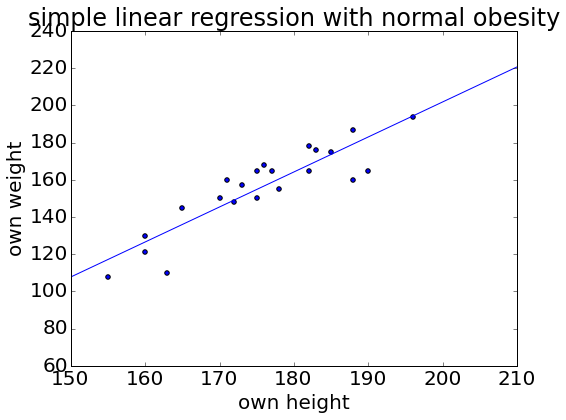

In [149]:
plt.scatter(phdata,pwdata)
x = np.array([100, 300])
y = c + m*x
plt.plot(x,y)
plt.xlabel('own height')
plt.ylabel('own weight')
plt.axis([150,210,60,240])
plt.title('simple linear regression with normal obesity')

In [150]:
h = np.mean(hdata)
herr = np.std(hdata)/np.sqrt(len(hdata)-1)
w = c + m*h
err = np.sqrt(yerr**2 + (herr*m)**2)
print('Phil\'s height = ' + str(h) + '+-' + str(herr))
print('Phil\'s weight = ' +  str(w) + '+-' + str(err))

Phil's height = 180.182105263+-1.01772283379
Phil's weight = 164.559353033+-10.0769840478


### Phil's weight = 165 $\pm$ 10 (lbs)

# 2.1 machine learning
Given age and height, train for weight.

In [119]:
from sklearn import linear_model
from sklearn import neighbors
import sklearn as sk
from sklearn.cross_validation import train_test_split
linear = linear_model.LinearRegression()

In [136]:
#prepare data
BMIlist = data['ownweight']*0.4534/data['ownheight']**2*100**2
select = np.where(np.logical_and(BMIlist > 12.1, BMIlist < 31.4))[0]


X, y = np.vstack((data['ownheight'],data['ownage'])).T[select], np.array(data['ownweight'][select])
X_scaled = sk.preprocessing.scale(X) # Many methods work better on scaled X.

### KNN tuning

In [145]:
KNN = neighbors.KNeighborsRegressor(5)
# We'll vary the number of neighbors used:
param_name = "n_neighbors"
param_range = np.array([1,2,4,6,8,10,14,16,18])

# And we'll need a cv iterator:
from sklearn.cross_validation import ShuffleSplit
shuffle_split = ShuffleSplit(len(X), 100, test_size=0.4)

# Compute our cv scores for a range of the no. of neighbors:
from sklearn.learning_curve import validation_curve
training_scores, validation_scores = validation_curve(KNN, X_scaled, y,
                                                      param_name=param_name,
                                                      param_range=param_range, 
                                                      cv=shuffle_split, scoring='r2')

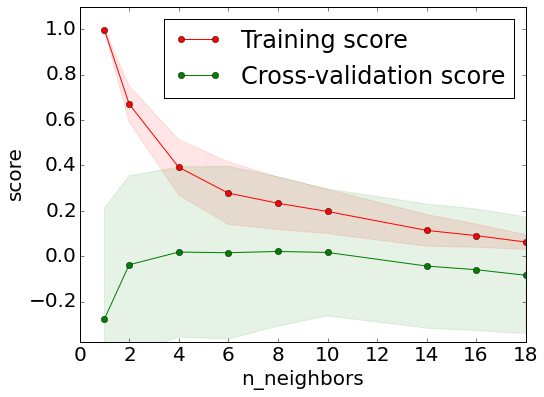

In [146]:
def plot_validation_curve(param_name,parameter_values, training_scores, validation_scores):
    training_scores_mean = np.mean(training_scores, axis=1)
    training_scores_std = np.std(training_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(parameter_values, training_scores_mean - training_scores_std,
                     training_scores_mean + training_scores_std, alpha=0.1, color="r")
    plt.fill_between(parameter_values, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(parameter_values, training_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(parameter_values, validation_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.ylim(validation_scores_mean.min() - .1, training_scores_mean.max() + .1)
    plt.ylabel('score')
    plt.xlabel(param_name)
    plt.legend(loc="best")
plot_validation_curve(param_name, param_range, training_scores, validation_scores)

In [124]:
shuffle_split = ShuffleSplit(len(X), 1000, test_size=0.4)
score_linear = []
for train_index,test_index in shuffle_split:
    linear.fit(X[train_index],y[train_index])
    score_linear.append(linear.score(X[test_index],y[test_index]))
print(np.mean(score_linear))
print(np.std(score_linear))

0.149453945064
0.336823072143


### score for linear fit: 0.15 $\pm$ 0.36

In [153]:
h = np.mean(hdata)
a = np.mean(data['age'])
aerr = np.std(data['age'])/np.sqrt(len(data['age']))
print(a,aerr)

(41.0, 0.77173043676922015)


In [126]:
linear.fit(X, y)
linear.predict([h,a])

array([ 169.82916754])

In [127]:
KNN = sk.neighbors.KNeighborsRegressor(8)
KNN.fit(X,y)
KNN.predict([h,a])

array([ 158.])